# Predict flight prices

# Load and take a look at the data

In [43]:
# Load relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [44]:
# Load data
ds=pd.read_csv('Flight_Data_Train.csv')
ds_test=pd.read_csv('Flight_Test_set.csv')
ds_sample=pd.read_csv('Flight_Sample_submission.csv')

In [45]:
ds.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [46]:
ds_test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL ? BOM ? COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? MAA ? BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL ? BOM ? COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL ? BOM ? COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR ? DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [47]:
ds.shape

(10683, 11)

In [48]:
ds.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

# Check and treat null values

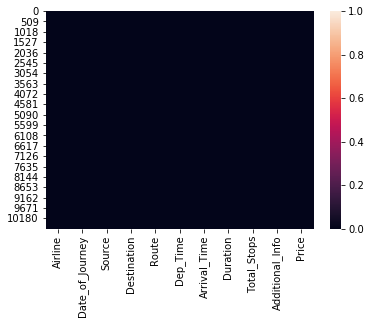

In [49]:
sns.heatmap(ds.isnull())

In [50]:
ds.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

Only two null values, since there are so few I will remove both rows from the dataset.

In [51]:
# Remove all rows with null values from dataset
ds=ds.dropna()

In [52]:
ds.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [53]:
ds_test.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64

No null values in the test set.

In [54]:
# Create new colum which reflects if the arrival date is the same date as departure
cond1 = ds.Arrival_Time.str.contains('\w\w\w')
ds['Next day Arrival'] = np.where(cond1, 'Next day','Same day') 

In [55]:
ds.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Next day Arrival
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,Next day
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662,Same day
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,Next day
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218,Same day
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302,Same day


In [56]:
# Remove the part of the arrival time that is the date
ds['Arrival_Time'] = ds['Arrival_Time'].str.replace('\d\d \w\w\w','')


In [57]:
ds.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Next day Arrival
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10,2h 50m,non-stop,No info,3897,Next day
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662,Same day
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25,19h,2 stops,No info,13882,Next day
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218,Same day
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302,Same day


In [58]:
ds.dtypes

Airline             object
Date_of_Journey     object
Source              object
Destination         object
Route               object
Dep_Time            object
Arrival_Time        object
Duration            object
Total_Stops         object
Additional_Info     object
Price                int64
Next day Arrival    object
dtype: object

In [59]:
ds.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price', 'Next day Arrival'],
      dtype='object')

In [60]:
# Create new colum which reflects if the arrival date is the same date as departure
cond2 = ds_test.Arrival_Time.str.contains('\w\w\w')
ds_test['Next day Arrival'] = np.where(cond2, 'Next day','Same day') 

In [61]:
# Remove the part of the arrival time that is the date
ds_test['Arrival_Time'] = ds_test['Arrival_Time'].str.replace('\d\d \w\w\w','')


In [62]:
ds_test.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Next day Arrival
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL ? BOM ? COK,17:30,04:25,10h 55m,1 stop,No info,Next day
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? MAA ? BLR,06:20,10:20,4h,1 stop,No info,Same day
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL ? BOM ? COK,19:15,19:00,23h 45m,1 stop,In-flight meal not included,Next day
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL ? BOM ? COK,08:00,21:00,13h,1 stop,No info,Same day
4,Air Asia,24/06/2019,Banglore,Delhi,BLR ? DEL,23:55,02:45,2h 50m,non-stop,No info,Next day


# Data visualizations

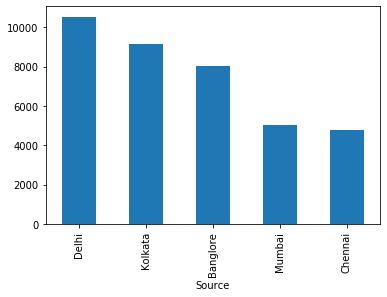

In [63]:
# Show mean price by source
ds.groupby('Source')['Price'].mean().sort_values(ascending=False).head(51).plot.bar()

Flights from delhi are the most expensive on average and least expensive from Chennai.

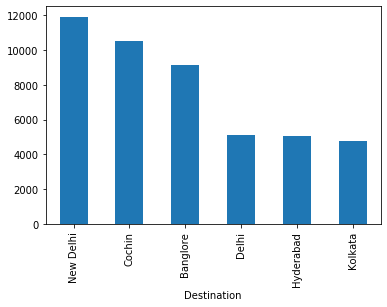

In [64]:
# Show mean price by destination
ds.groupby('Destination')['Price'].mean().sort_values(ascending=False).head(51).plot.bar()

Flights to Delhi are the most expensive on average and to Kolkutta the most expensive.

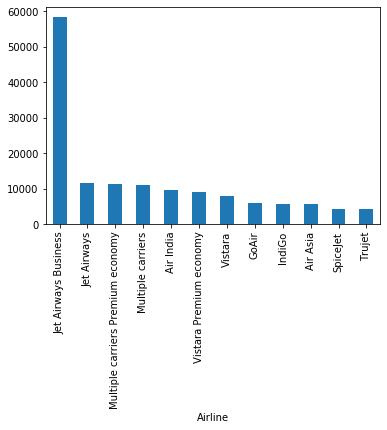

In [65]:
# Show mean price by airline
ds.groupby('Airline')['Price'].mean().sort_values(ascending=False).head(51).plot.bar()

Jet Airways is by far the most expensive on average and trujet the cheapest.

# Encode categorical columns to numeric values

In [66]:
eds=ds

In [67]:
eds.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price', 'Next day Arrival'],
      dtype='object')

In [68]:
eds.dtypes

Airline             object
Date_of_Journey     object
Source              object
Destination         object
Route               object
Dep_Time            object
Arrival_Time        object
Duration            object
Total_Stops         object
Additional_Info     object
Price                int64
Next day Arrival    object
dtype: object

In [69]:
# Change categorical data to numerical data for 2 categoriacl columns

from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
cols=['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info','Next day Arrival']
for col in cols:
    ds[col] = le.fit_transform(ds[col])

In [70]:
eds.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Next day Arrival
0,3,24,0,5,18,211,12,240,4,8,3897,0
1,1,6,3,0,84,31,137,336,1,8,7662,1
2,4,43,2,1,118,70,31,106,1,8,13882,0
3,3,10,3,0,91,164,294,311,0,8,6218,1
4,3,0,0,5,29,149,262,303,0,8,13302,1


In [71]:
# Change categorical data to numerical data test set

from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
cols=['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info','Next day Arrival']
for col in cols:
    ds_test[col] = le.fit_transform(ds_test[col])

# Check correlation after encoding

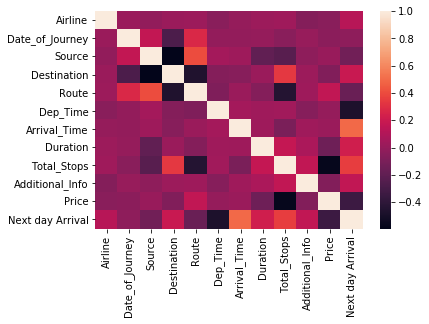

In [72]:
dscor=eds.corr()
sns.heatmap(dscor)

Best correlated to the target column: route
    next: Source, Dep_Time, Arrival_Time
        After that: Airline, Date of journey, Destination, Duration, Additional info
            Poorlu or negative correlation: Total stops, Next day arrival

# Summary statistics

In [73]:
eds.describe()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Next day Arrival
count,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000,10682.000000
mean,3.966205,23.733758,1.952256,1.436154,74.820165,107.983898,150.551863,194.072177,1.458248,7.392998,9087.214567,0.594271
std,2.352090,12.337569,1.177276,1.474845,36.729039,61.087537,91.460755,108.625225,1.806320,1.214254,4611.548810,0.491056
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1759.000000,0.000000
25%,3.000000,14.000000,2.000000,0.000000,48.000000,55.000000,62.000000,106.000000,0.000000,8.000000,5277.000000,0.000000
50%,4.000000,24.000000,2.000000,1.000000,73.000000,96.000000,150.000000,233.000000,0.000000,8.000000,8372.000000,1.000000
75%,4.000000,35.000000,3.000000,2.000000,104.000000,164.000000,226.000000,280.000000,4.000000,8.000000,12373.000000,1.000000
max,11.000000,43.000000,4.000000,5.000000,127.000000,221.000000,301.000000,367.000000,4.000000,9.000000,79512.000000,1.000000


# Drop irrelevant columns

In [74]:
ds.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price', 'Next day Arrival'],
      dtype='object')

Best correlated to the target column: route
    next: Source, Dep_Time, Arrival_Time
        After that: Airline, Date of journey, Destination, Duration, Additional info
            Poorlu or negative correlation: Total stops, Next day arrival

In [75]:
# Drop irrelevant (poorly correlated) columns - dataset renamed to nds (new dataset)
nds=ds.drop(columns=['Total_Stops', 'Next day Arrival'])

In [76]:
# Drop the same columns from the test set
nds_test=ds_test.drop(columns=['Total_Stops', 'Next day Arrival'])

# Find and remove outliers

In [77]:
nds.shape

(10682, 10)

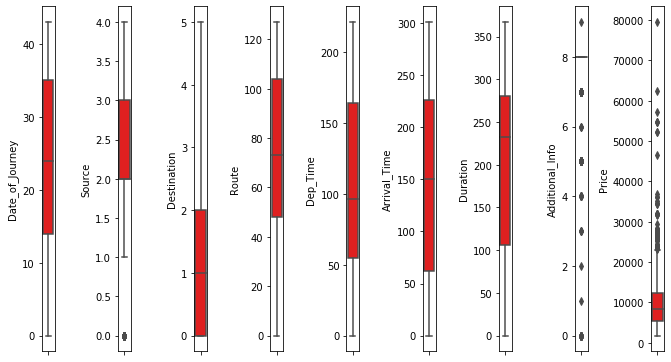

In [78]:
# Show boxplots for all columns, check outliers
collist=nds.columns.values
ncol=10
nrows=10

plt.figure(figsize=(ncol,5*ncol))
for i in range(1, len(collist)):
    plt.subplot(nrows,ncol,i+1)
    sns.boxplot(nds[collist[i]], color='red', orient='v')
    plt.tight_layout()

In [79]:
# Remove outliers - dataset renamed to cds (clean dataset)
from scipy import stats
from scipy.stats import zscore

z_score=abs(zscore(nds))
print(nds.shape)
cds=nds.loc[(z_score<3).all(axis=1)]
print(cds.shape)

(10682, 10)
(10577, 10)


In [80]:
# Remove outliers from testset
from scipy import stats
from scipy.stats import zscore

z_score=abs(zscore(nds_test))
print(nds_test.shape)
cds_test=nds_test.loc[(z_score<3).all(axis=1)]
print(cds_test.shape)

(2671, 9)
(2668, 9)


# Check and adjust skewness

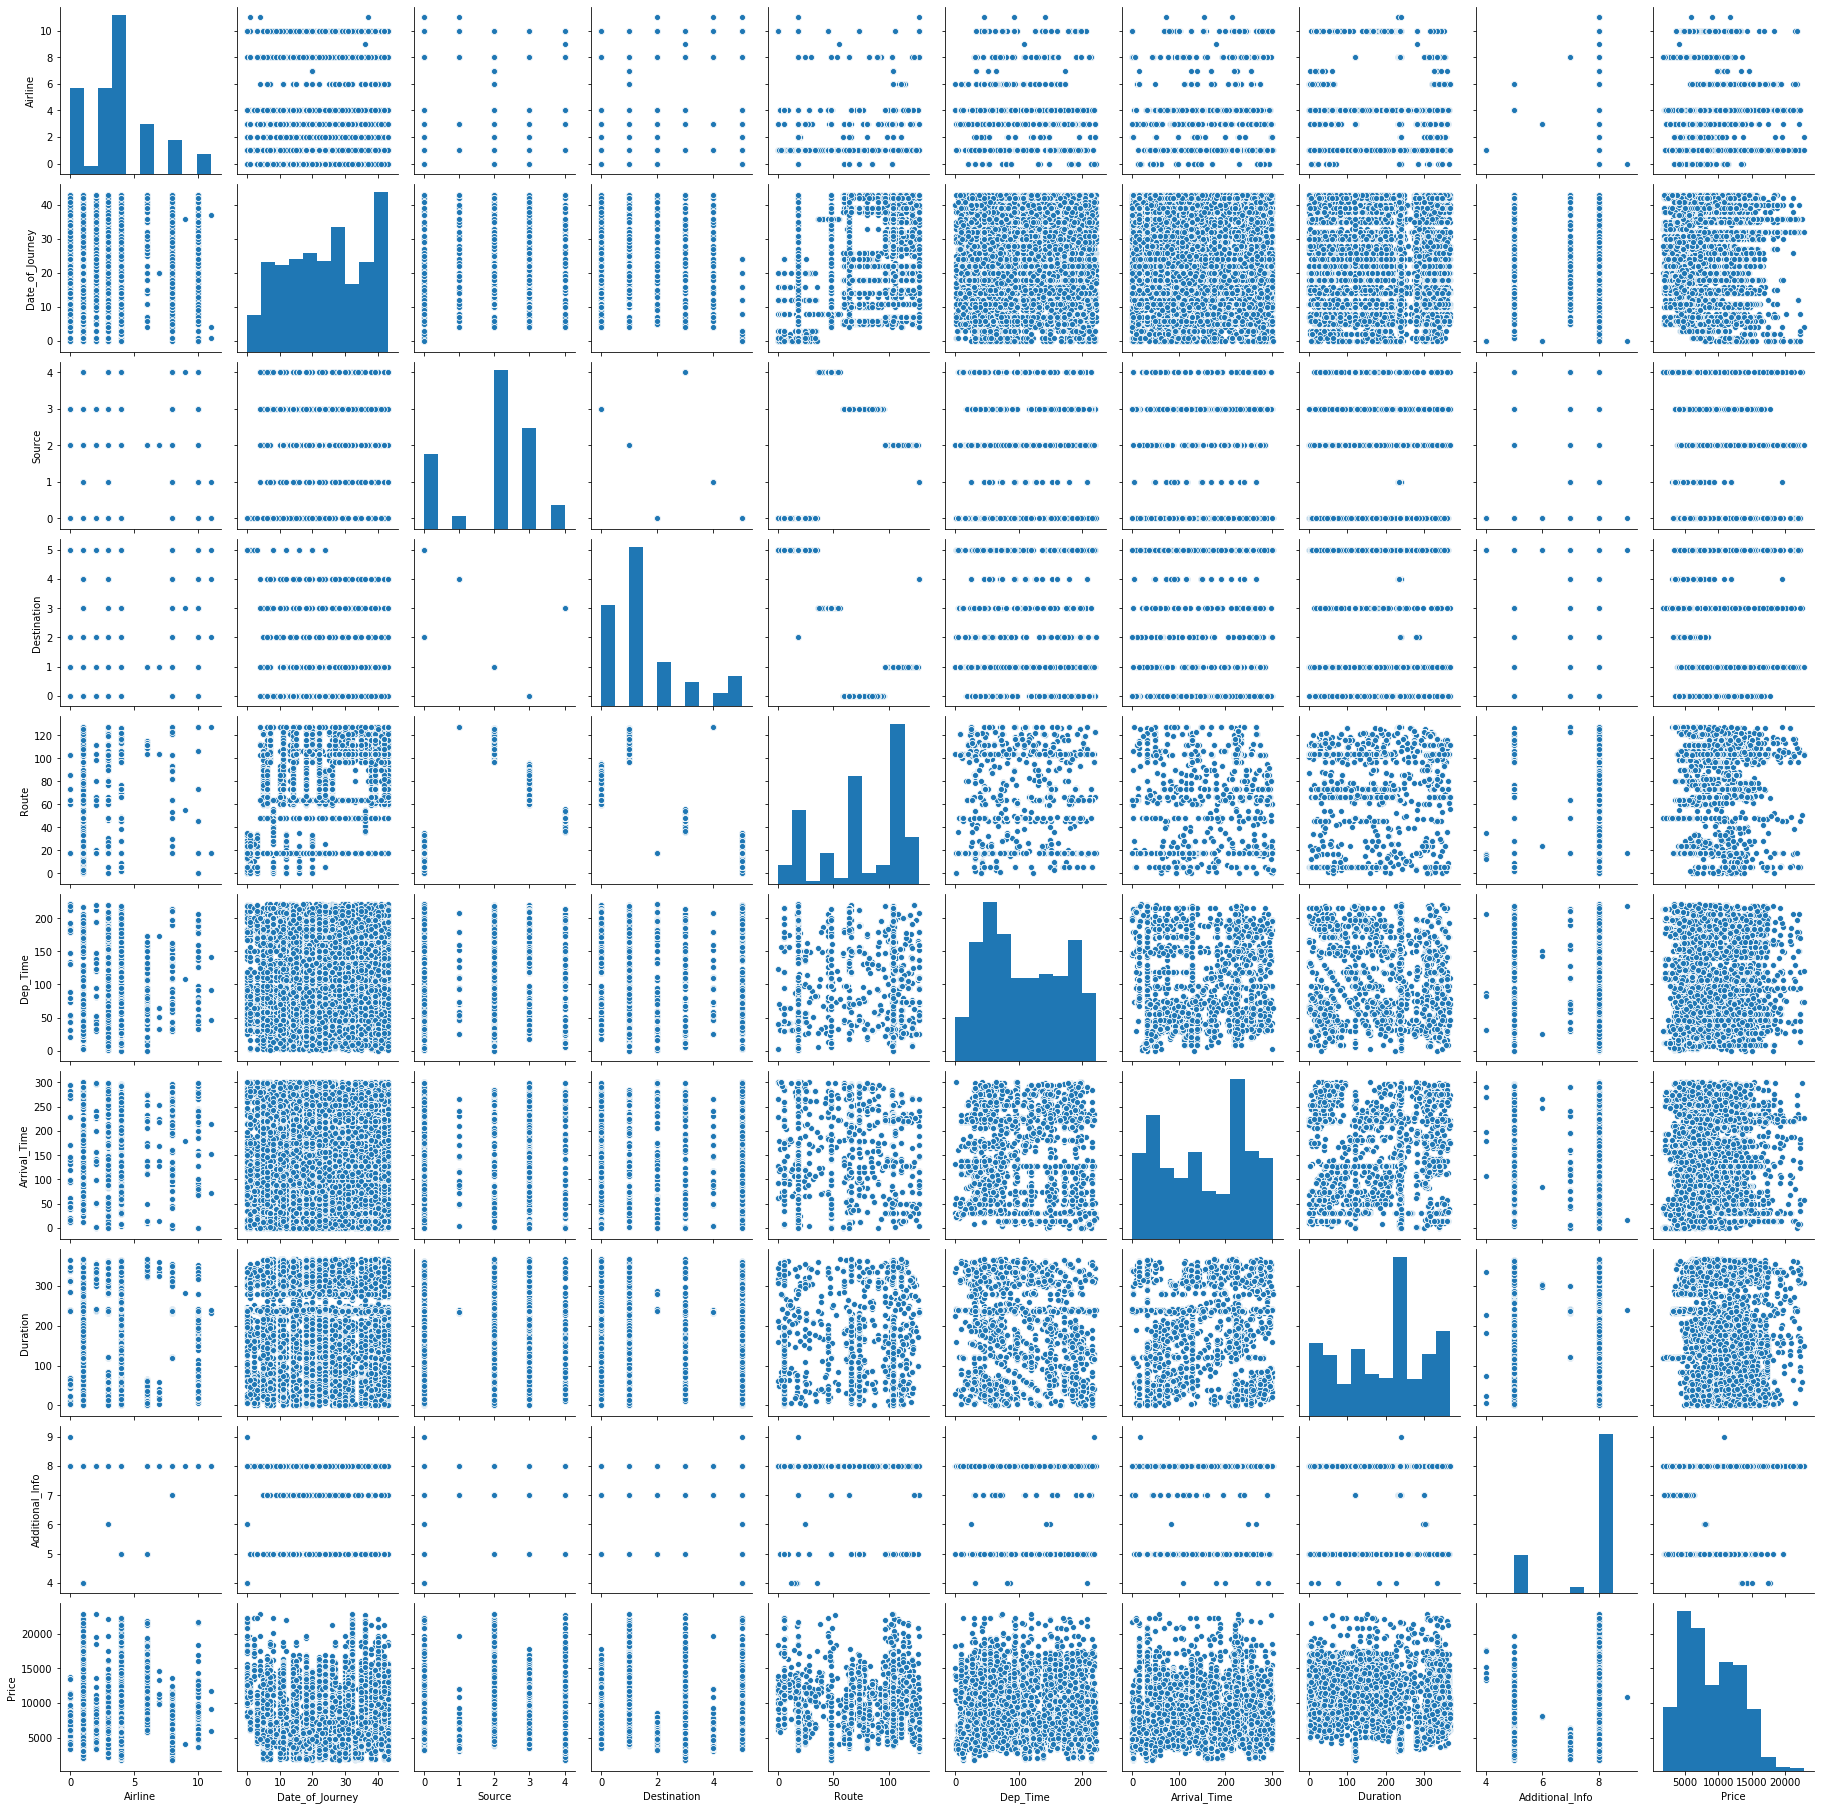

In [81]:
# Checking pairplots
sns.pairplot(cds)
plt.show()

In [82]:
# Show skewness (less than 0.55 is ok)
cds.skew()

Airline            0.731671
Date_of_Journey   -0.061745
Source            -0.439175
Destination        1.269331
Route             -0.511212
Dep_Time           0.193999
Arrival_Time      -0.087567
Duration          -0.216167
Additional_Info   -1.533439
Price              0.410987
dtype: float64

In [83]:
#Treat skewness using log
for col in cds.columns:
    if cds.skew().loc[col]>0.55:
        cds[col]=np.log1p(cds[col])

In [84]:
cds.skew()

Airline           -0.677720
Date_of_Journey   -0.061745
Source            -0.439175
Destination        0.284917
Route             -0.511212
Dep_Time           0.193999
Arrival_Time      -0.087567
Duration          -0.216167
Additional_Info   -1.533439
Price              0.410987
dtype: float64

In [85]:
cds_test.skew()

Airline            0.483962
Date_of_Journey   -0.043201
Source            -0.427200
Destination        1.267547
Route             -0.283180
Dep_Time           0.177321
Arrival_Time      -0.183443
Duration          -0.275822
Additional_Info   -1.659418
dtype: float64

In [86]:
#Treat skewness using log for test set
for col in cds_test.columns:
    if cds_test.skew().loc[col]>0.55:
        cds_test[col]=np.log1p(cds_test[col])

# Split data into x and y

In [87]:
cds.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Additional_Info', 'Price'],
      dtype='object')

In [88]:
# Lineup target and input values
cds_x=cds.drop(columns=['Price'])
y=cds[['Price']]

# Apply scaler

In [89]:
#Scaling for linear regression
from sklearn.preprocessing import StandardScaler

sc=StandardScaler()
x=sc.fit_transform(cds_x)
x=pd.DataFrame(x,columns=cds_x.columns)

In [90]:
x.skew()

Airline           -0.677720
Date_of_Journey   -0.061745
Source            -0.439175
Destination        0.284917
Route             -0.511212
Dep_Time           0.193999
Arrival_Time      -0.087567
Duration          -0.216167
Additional_Info   -1.533439
dtype: float64

In [91]:
#Scaling for linear regression
from sklearn.preprocessing import StandardScaler

sc2=StandardScaler()
testx=sc2.fit_transform(cds_test)
testx=pd.DataFrame(testx,columns=cds_test.columns)

# Train-Test split

In [92]:
# Train test split
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test = train_test_split(x,y, random_state=55, test_size=0.20)

# Model

In [93]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.externals import joblib
from sklearn import linear_model

In [94]:
# Error calculation
max_r_score=0
for r_state in range(42,100):
    x_train,x_test, y_train, y_test = train_test_split(x,y, random_state=r_state, test_size=0.20)
    regr=linear_model.LinearRegression()
    regr.fit(x_train,y_train)
    y_pred=regr.predict(x_test)
    r2_scr=r2_score(y_test,y_pred)
    if r2_scr>max_r_score:
        max_r_score=r2_scr
        final_r_state=r_state
print("Max r2 score for",final_r_state,"is", max_r_score)

Max r2 score for 51 is 0.14392439002085544


In [95]:
# Crossvalidation
cross_val_score(linear_model.LinearRegression(),x,y,cv=10,scoring='r2').mean()

0.12347729827161483

In [96]:
# R2 score gives us a rondom state of 51
x_train,x_test, y_train, y_test = train_test_split(x,y, random_state=51, test_size=0.20)
lreg=linear_model.LinearRegression()
lreg.fit(x_train,y_train)
y_pred=lreg.predict(x_test)

In [97]:
# R2 and Mean squared error statements
print('r score is: ',r2_score(y_test,y_pred))
print('RMSE is: ', np.sqrt(mean_squared_error(y_test, y_pred)))

r score is:  0.14392439002085544
RMSE is:  3746.105091033129


# Other regression models

In [98]:
# Loop for SVR types
from sklearn.svm import SVR

kernellist=['linear','poly','rbf']
for i in kernellist:
    sv=SVR(kernel=i)
    sv.fit(x_train,y_train)
    print(sv.score(x_train,y_train))

0.06673806324300524
0.011940277520950837
0.01600693863160696


In [99]:
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import datasets
# Prepare a range of alpha values to test
alphavalue={'alpha':[1,0.1,0.01,0.001,0.0001,0]}
# Create and fit a Ridge regression model to test each alpha
model=Ridge()
grid=GridSearchCV(estimator=model,param_grid=alphavalue)
grid.fit(x_train,y_train)

#Summarize the results of the grid search

print(grid.best_estimator_.alpha)

1


In [100]:
# Create and fit a Ridge regression model to test each alpha
model2=Lasso()
grid=GridSearchCV(estimator=model2,param_grid=alphavalue)
grid.fit(x_train,y_train)

#Summarize the results of the grid search

print(grid.best_estimator_.alpha)

0.1


In [101]:
# x_train,x_test,y_train, y_test
# Try to minimize the coefficient variance

rd=Ridge(alpha=1)
rd.fit(x_train,y_train)
rd.score(x_train,y_train)

0.12037748453801744

In [102]:
# Cross validation score for Ridge Regressor
cross_val_score(linear_model.Ridge(alpha=1),x,y,cv=10,scoring='r2').mean()

0.12347754570586111

In [103]:
# x_train,x_test,y_train, y_test
# Try to minimize the coefficient variance

las=Lasso(alpha=0.1)
las.fit(x_train,y_train)
las.score(x_train,y_train)

0.12037748109070989

In [104]:
# Use Gradient Boosting technique with GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

gbr=GradientBoostingRegressor()
parameters={'learning_rate':[0.001,0.01,0.1,1],'n_estimators':[10,100,500,1000]}
clf=GridSearchCV(gbr,parameters, cv=5)
clf.fit(x,y)
clf.best_params_

{'learning_rate': 1, 'n_estimators': 1000}

In [105]:
# Use CrossValScore with Gradient Boosting to check r2 mean and standard deviation
gbr=GradientBoostingRegressor(learning_rate= 0.1, n_estimators=1000)
print('Mean r2 score for GradientBoosting Regression:', cross_val_score(gbr,x,y,cv=5,scoring='r2').mean())
print('Standard deviation in r2 score for GradientBoosting Regression:',cross_val_score(gbr,x,y,cv=5,scoring='r2').std())

Mean r2 score for GradientBoosting Regression: 0.9028084245085385
Standard deviation in r2 score for GradientBoosting Regression: 0.004480807309427849


In [111]:
gbr=GradientBoostingRegressor(learning_rate= 0.1, n_estimators=1000)
gbr.fit(x_train,y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

I choose the GradientBoostingRegressor model because it has the best score

Mean r2 score for GradientBoosting Regression: 90.3
Standard deviation in r2 score for GradientBoosting Regression: 0.45

# Save the model

In [113]:
#save model as a pickle file
from sklearn.externals import joblib
joblib.dump(gbr,'Flights.pkl')

['Flights.pkl']

In [114]:
# Load and use model to make a prediction
model=joblib.load('Flights.pkl')
model.predict(testx)

array([ 5160.29929971,  8445.6613455 , 14042.01134908, ...,
        7725.4949358 , 18546.35995238, 11706.23328412])